# Spam-Ham Classifier

- Using a RNN sms classifier model by applying PyTorch. 

- The classifier is trained on Ham-Spam dataset.<br>

https://www.kaggle.com/ishansoni/sms-spam-collection-dataset

# 1)- Import key modules

In [0]:
from pathlib import Path

import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from google_drive_downloader import GoogleDriveDownloader as gdd
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm, tqdm_notebook

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 2)- Loading data

https://www.kaggle.com/ishansoni/sms-spam-collection-dataset

In [0]:
DATA_PATH = 'SMSSpamCollection.csv'

In [4]:
# View some example records
df=pd.read_csv(DATA_PATH,delimiter='\t', quoting=3,names=['label','sms'])
df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.shape

(5574, 2)

In [0]:
df['label'] = pd.get_dummies(df.label, prefix='label').iloc[:,1:]

In [7]:
df.head()

,label,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
df.to_csv('sms.csv', index=False)

In [0]:
DATA_PATH='sms.csv'

In [10]:
pd.read_csv(DATA_PATH).head()

,label,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# 3)-Preprocess the text

In [0]:
vectorizer = CountVectorizer(stop_words='english', max_df=0.99, min_df=0.015)

In [0]:
sequences = vectorizer.fit_transform(df.sms.tolist())

In [13]:
sequences

<5574x65 sparse matrix of type '<class 'numpy.int64'>'
	with 9743 stored elements in Compressed Sparse Row format>

In [14]:
print(pd.DataFrame(sequences).head(2))

                                          0
0    (0, 13)\t1\n  (0, 12)\t1\n  (0, 57)\t1
1                                (0, 37)\t1


In [0]:
token2idx = vectorizer.vocabulary_

In [16]:
token2idx

{'claim': 0,
 'come': 1,
 'da': 2,
 'day': 3,
 'dear': 4,
 'did': 5,
 'doing': 6,
 'don': 7,
 'dont': 8,
 'free': 9,
 'going': 10,
 'good': 11,
 'got': 12,
 'great': 13,
 'gt': 14,
 'happy': 15,
 'hey': 16,
 'hi': 17,
 'home': 18,
 'hope': 19,
 'just': 20,
 'know': 21,
 'later': 22,
 'like': 23,
 'll': 24,
 'lor': 25,
 'love': 26,
 'lt': 27,
 'make': 28,
 'message': 29,
 'mobile': 30,
 'msg': 31,
 'need': 32,
 'new': 33,
 'night': 34,
 'number': 35,
 'oh': 36,
 'ok': 37,
 'phone': 38,
 'pls': 39,
 'prize': 40,
 'reply': 41,
 'right': 42,
 'say': 43,
 'send': 44,
 'sorry': 45,
 'stop': 46,
 'tell': 47,
 'text': 48,
 'think': 49,
 'time': 50,
 'today': 51,
 'tomorrow': 52,
 'txt': 53,
 'ur': 54,
 've': 55,
 'want': 56,
 'wat': 57,
 'way': 58,
 'week': 59,
 'won': 60,
 'work': 61,
 'www': 62,
 'yeah': 63,
 'yes': 64}

In [17]:
token2idx['sorry']

45

**All in one**

In [0]:
class Sequences(Dataset):
    def __init__(self, path, max_seq_len):
        self.max_seq_len = max_seq_len
        df = pd.read_csv(path)
        vectorizer = CountVectorizer(stop_words='english', min_df=0.015)
        vectorizer.fit(df.sms.tolist())
        
        self.token2idx = vectorizer.vocabulary_
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1 # for removing zeros

        tokenizer = vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x)
                                 if token in self.token2idx]
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['<PAD>']]
        
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df.sms.tolist()]
        sequences, self.labels = zip(*[(sequence, label) for sequence, label
                                    in zip(sequences, df.label.tolist()) if sequence])
        self.sequences = [self.pad(sequence) for sequence in sequences]

    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)

In [0]:
dataset = Sequences(DATA_PATH, max_seq_len=16)

In [20]:
len(dataset.token2idx)

66

In [0]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.FloatTensor([item[1] for item in batch])
    return inputs, target

batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate)

**What is collate?**

https://discuss.pytorch.org/t/how-to-use-collate-fn/27181/2

# 4)- GRU Model Building

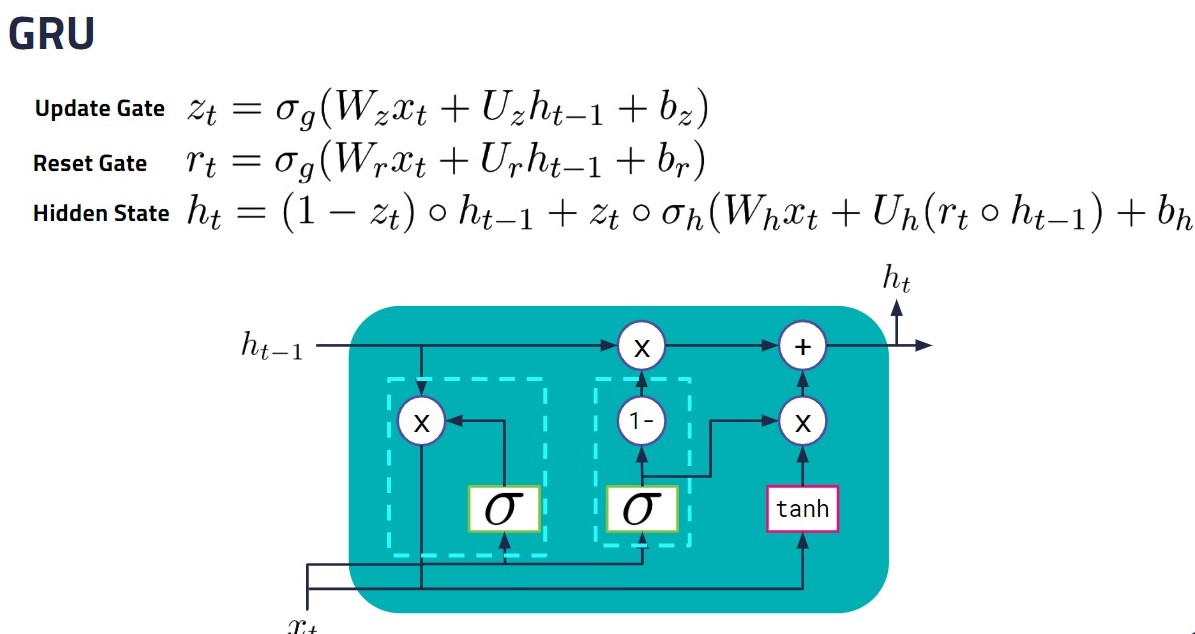

In [22]:
from IPython.display import Image
Image("GRU.jpg")

In [0]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        batch_size,
        embedding_dimension=10,
        hidden_size=16, 
        n_layers=1,
        device='cuda',
    ):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.batch_size = batch_size
        
        self.encoder = nn.Embedding(vocab_size, embedding_dimension)
        self.rnn = nn.GRU(
            embedding_dimension,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
        self.decoder = nn.Linear(hidden_size, 1)
        
    def init_hidden(self):
        return torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device)
    
    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
            
        encoded = self.encoder(inputs)
        output, hidden = self.rnn(encoded, self.init_hidden())
        output = self.decoder(output[:, :, -1]).squeeze()
        return output

In [24]:
model = RNN(
    hidden_size=16,
    vocab_size=len(dataset.token2idx),
    device=device,
    batch_size=batch_size,
)
model = model.to(device)
model

RNN(
  (encoder): Embedding(66, 10)
  (rnn): GRU(10, 16, batch_first=True)
  (decoder): Linear(in_features=16, out_features=1, bias=True)
)

# 5)- Train the model

In [0]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)# Adam: Dynmaically change learning rate

**Binary crossentropy(BCEWithLogitsLoss)**<br>

It's called Binary Cross-Entropy Loss because it sets up a binary classification problem between C′=2 classes for every class in C i.e Spam or Ham sms text.

In [26]:
model.train()
train_losses = []
for epoch in range(50): # epoch size
    progress_bar = tqdm_notebook(train_loader, leave=False)
    losses = []
    total = 0
    for inputs, target in progress_bar:
        inputs, target = inputs.to(device), target.to(device
                                                     )
        model.zero_grad()
        
        output = model(inputs)
    
        loss = criterion(output, target)
        
        loss.backward()
              
        nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)

    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')

Epoch #1	Train Loss: 0.504


Epoch #2	Train Loss: 0.419


Epoch #3	Train Loss: 0.376


Epoch #4	Train Loss: 0.286


Epoch #5	Train Loss: 0.224


Epoch #6	Train Loss: 0.206


Epoch #7	Train Loss: 0.191


Epoch #8	Train Loss: 0.182


Epoch #9	Train Loss: 0.172


Epoch #10	Train Loss: 0.171


Epoch #11	Train Loss: 0.166


Epoch #12	Train Loss: 0.164


Epoch #13	Train Loss: 0.159


Epoch #14	Train Loss: 0.155


Epoch #15	Train Loss: 0.155


Epoch #16	Train Loss: 0.148


Epoch #17	Train Loss: 0.148


Epoch #18	Train Loss: 0.153


Epoch #19	Train Loss: 0.143


Epoch #20	Train Loss: 0.144


Epoch #21	Train Loss: 0.148


Epoch #22	Train Loss: 0.140


Epoch #23	Train Loss: 0.138


Epoch #24	Train Loss: 0.140


Epoch #25	Train Loss: 0.139


Epoch #26	Train Loss: 0.138


Epoch #27	Train Loss: 0.138


Epoch #28	Train Loss: 0.139


Epoch #29	Train Loss: 0.136


Epoch #30	Train Loss: 0.137


Epoch #31	Train Loss: 0.130


Epoch #32	Train Loss: 0.130


Epoch #33	Train Loss: 0.130


Epoch #34	Train Loss: 0.129


Epoch #35	Train Loss: 0.126


Epoch #36	Train Loss: 0.132


Epoch #37	Train Loss: 0.126


Epoch #38	Train Loss: 0.129


Epoch #39	Train Loss: 0.125


Epoch #40	Train Loss: 0.128


Epoch #41	Train Loss: 0.127


Epoch #42	Train Loss: 0.125


Epoch #43	Train Loss: 0.125


Epoch #44	Train Loss: 0.130


Epoch #45	Train Loss: 0.124


Epoch #46	Train Loss: 0.123


Epoch #47	Train Loss: 0.120


Epoch #48	Train Loss: 0.123


Epoch #49	Train Loss: 0.124


Epoch #50	Train Loss: 0.123


# 6)- Prediction

In [0]:
def predict_sms(text):
    model.eval()
    with torch.no_grad():
        test_vector = torch.LongTensor([dataset.pad(dataset.encode(text))]).to(device)
        
        output = model(test_vector)
        prediction = torch.sigmoid(output).item()

        if prediction > 0.5:
            print(f'{prediction:0.3}: Spam SMS')
        else:
            print(f'{prediction:0.3}: Ham SMS')

In [28]:
test_text = """
Congratulations! Thanks to a good friend U have WON the £2,000 Xmas prize. 2 claim is easy, just call 08718726971 NOW! Only 10p per minute. BT-national-rate.
"""
predict_sms(test_text)

0.992: Spam SMS


In [29]:
test_text = """
Have you had a good day? Mine was really busy are you up to much tomorrow night? 
"""
predict_sms(test_text)

0.014: Ham SMS


In [30]:
test_text = """
FREE UNLIMITED HARDCORE PORN direct 2 your mobile Txt PORN to 69200 & get FREE access for 24 hrs then chrgd@50p per day txt Stop 2exit. This msg is free
"""
predict_sms(test_text)

0.996: Spam SMS


**In this case, first we have sigmoid value (between 0 and 1).It will be higher i.e >.5 for Spam and less i.e <.5 for Ham. Then we have result of our prediction.**